In [ ]:
################################################################################
# FEDERAL UNIVERSITY OF CATALÃO (UFCAT)
# DEVELOPERS:
# PROF. WANDERLEI MALAQUIAS PEREIRA JUNIOR, Ph.D. (UFCAT / FENG)
# DR. ANDRÉ TEOFILO BECK, Ph.D. (USP / EESC)
# GITHUB: wwww.linklink.com.br
# LICENSE: aqui verificar
################################################################################

################################################################################
# DESCRIPTION SCRIPT:

# LIBRARY FOR DETERMINING THE RELIABILITY OF REINFORCED CONCRETE BEAMS IN ACCOR-
# DANCE WITH BRAZILIAN CODE NBR 6118:2014
################################################################################

################################################################################
# LIBRARIES
# NATIVE PYTHON
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# GPEE DEVELOPERS
def STATE_I_GEOMETRIC_PROPERTIES(h, bf, bw, hf, asTrac, alfa, d):
    area = (bf - bw)*hf + bw*h + asTrac*(alfa - 1)
    linhaNeutra = ((bf - bw)*((hf**2)/2) + bw*((h**2)/2) + asTrac*(alfa - 1)*d)/area
    inercia = ((bf - bw)*hf**3)/12 + (bw*h**3)/12 + (bf - bw)*hf*(linhaNeutra - hf/2)**2 + bw*h*(linhaNeutra - h/2)**2 + asTrac*(alfa - 1)*(linhaNeutra - d)**2
    return area, linhaNeutra, inercia

def STATE_II_GEOMETRIC_PROPERTIES(h, bf, bw, hf, asTrac, asComp, alfa, d, dlinha):
    if bf <= bw:
        a1 = bw/2
        #print('d:',d, 'alfa:',alfa, 'astrac:',asTrac)
        #print('a1',a1)
        a2 = hf*(bf - bw) + (alfa - 1)*asComp + alfa*asTrac
        #print('a2',a2)
        a3 = - dlinha*(alfa - 1)*asComp - d*alfa*asTrac - ((hf**2)/2)*(bf - bw)
        #print('parte1', -dlinha*(alfa - 1)*asComp)
        #print('parte2', -d*alfa*asTrac)
        #print('parte3', - ((hf**2)/2)*(bf - bw))
        #print(a3)
        linhaNeutra = (-a2 + np.sqrt(a2**2 - 4*a1*a3))/(2*a1)
        #print(linhaNeutra)
    elif bf > bw:
        a1 = bf/2
        a2 = hf*(0) + (alfa - 1)*asComp + alfa*asTrac
        a3 = -dlinha*(alfa - 1)*asComp - d*alfa*asTrac - (hf**2)/2*(0)
        linhaNeutra = (-a2 + (a2**2 - 4*a1*a3)**0.50)/(2*a1)
        if linhaNeutra > hf:
            a1 = bw/2
            a2 = hf*(bf - bw) + (alfa - 1)*asComp + alfa*asTrac
            a3 = -dlinha*(alfa - 1)*asComp - d*alfa*asTrac - (hf**2)/2*(bf - bw)
            linhaNeutra = (-a2 + np.sqrt(a2**2 - 4*a1*a3))/(2*a1)    
    if linhaNeutra <= hf:
        inercia = (bf*linhaNeutra**3)/3 + alfa*asTrac*(linhaNeutra - d)**2 + (alfa - 1)*asComp*(linhaNeutra - dlinha)**2
    else:
        inercia = ((bf - bw)*hf**3)/12 + (bw*linhaNeutra**3)/3 + (bf - bw)*(linhaNeutra - hf/2)**2 + alfa*asTrac*(linhaNeutra - d)**2 + (alfa - 1)*asComp*(linhaNeutra - dlinha)**2
    return linhaNeutra, inercia

def BRANSON_INERTIA(mr, mat, inerI, inerII):
    if mat <= mr:
        #print('estadio I')
        inerM = inerI
    elif mat > mr:
        #print('estadio II')
        mrmat = (mr/mat)**3
        #print('MrMat',mrmat)
        inerM = mrmat*inerI + (1 - mrmat)*inerII
        #print('inerM',inerM)
    return inerM

# LAMBDA FACTOR FOR NEUTRAL DEPTH CORRECTION OF THE EQUIVALENT DIAGRAM
def LAMBDA_FACTOR(FCK):
    if FCK <= 50:
        LAMBDA = 0.80
    elif FCK > 50:
        LAMBDA = 0.80 - (FCK - 50) / 400
    return LAMBDA

# ALPHAC FACTOR RUSH EFFECT CORRECTION
def ALPHAC_FACTOR(FCK):
    if FCK <= 50:
        ALPHAC = 0.85
    elif FCK > 50:
        ALPHAC = 0.85 * (1.00 - (FCK - 50) / 200)
    return ALPHAC

# NEUTRAL AXIS FORM FACTOR 
def SECTION_FORM_FACTOR(FACTOR_FORM):
    if FACTOR_FORM == 0:
        FACTOR_FORM_VALUE = 1.00
    elif FACTOR_FORM == 1:
        FACTOR_FORM_VALUE = 0.90
    return FACTOR_FORM_VALUE

# CALCULATION NEUTRAL AXIS DEPTH
def NEUTRAL_AXIS_CONCRETE_SECTION(EFFECTIVE_DEPTH, BENDING_MOMENT, WIDTH, ALPHAC, LAMBDA, FCK, GAMMA_M_CONCRETE):
    FCD = FCK / GAMMA_M_CONCRETE
    TERM_1 = 2 * BENDING_MOMENT / (WIDTH * ALPHAC * FCD)
    TERM_2 = np.sqrt(EFFECTIVE_DEPTH * EFFECTIVE_DEPTH - TERM_1)
    NUMERATOR = EFFECTIVE_DEPTH - TERM_2
    DENOMINATOR = LAMBDA
    NEUTRAL_AXIS_DEPTH = NUMERATOR / DENOMINATOR
    return NEUTRAL_AXIS_DEPTH

# CALCULATION LEVER ARM LENGTH
def LEVER_ARM_CONCRETE_SECTION(EFFECTIVE_DEPTH, NEUTRAL_AXIS_DEPTH, LAMBDA):
    LEVER_ARM_DEPTH = EFFECTIVE_DEPTH - 0.50 * LAMBDA * NEUTRAL_AXIS_DEPTH
    return LEVER_ARM_DEPTH

# STEEL REINFORCEMENT FOR BENDING MOMENT    
def BENDING_MOMENT_STEEL_REINFORCEMENT(STEEL_DENSITY, WIDTH, HEIGHT, BENDING_MOMENT, LEVER_ARM_DEPTH, FYK, GAMMA_M_STEEL):
    FYD = FYK / GAMMA_M_STEEL
    STEEL_AREA_BENDING_MOMENT = BENDING_MOMENT / (LEVER_ARM_DEPTH * FYD)
    MIN_STEEL_AREA_BENDING_MOMENT = STEEL_DENSITY * WIDTH * HEIGHT
    if STEEL_AREA_BENDING_MOMENT < MIN_STEEL_AREA_BENDING_MOMENT:
        STEEL_AREA_BENDING_MOMENT = MIN_STEEL_AREA_BENDING_MOMENT
    return STEEL_AREA_BENDING_MOMENT

# VRD2 VERIFICATION FOR SHEAR LOAD    
def VRD2_VERIFICATION(FCK, WIDTH, EFFECTIVE_DEPTH, GAMMA_M_CONCRETE):
    ALFA_V2 = 1 - ((FCK / 1E3) / 250)
    #print('alfav2', ALFA_V2)
    FCD = FCK / GAMMA_M_CONCRETE
    #print('fcd', FCD)
    #print('bw', WIDTH)
    #print('d', EFFECTIVE_DEPTH)
    #print('alfav2', ALFA_V2)
    VRD2 = 0.270 * ALFA_V2 * FCD * WIDTH * EFFECTIVE_DEPTH
    return VRD2

# CONCRETE CONTRIBUITION IN SHEAR DESIGN
def VC_VERIFICATION(FCK, WIDTH, EFFECTIVE_DEPTH, GAMMA_M_CONCRETE):
    FCTM = (0.30 * (FCK / 1E3) ** (2 / 3))
    #print('fck', FCK)
    #print('fctm', FCTM)
    FCTK_INF = 0.70 * FCTM
    FCTD = FCTK_INF / GAMMA_M_CONCRETE
    #print('fctd', FCTD)
    VC0 = 0.6 * (FCTD * 1E3) * WIDTH * EFFECTIVE_DEPTH
    #print('Vc0', VC0)
    VC = VC0
    return VC

# STEEL REINFORCEMENT FOR SHEAR LOAD
    
def SHEAR_STEEL_REINFORCEMENT(FCK, FYWK, WIDTH, EFFECTIVE_DEPTH, SHEAR_LOAD, GAMMA_M_CONCRETE, GAMMA_M_STEEL):
    VC = VC_VERIFICATION(FCK, WIDTH, EFFECTIVE_DEPTH, GAMMA_M_CONCRETE)
    FCTM = (0.30 * (FCK / 1E3) ** (2 / 3))
    #print('Vc: ', VC)
    VSW = SHEAR_LOAD - VC 
    #print('Vsw: ', VSW)
    MIN_STEEL_AREA_SHEAR = ((20 * FCTM / 10) / 50) * (WIDTH * 100)
    #print('Asw,min: ', MIN_STEEL_AREA_SHEAR)
    if VSW <= 0:
        STEEL_AREA_SHEAR = MIN_STEEL_AREA_SHEAR
    elif VSW > 0:
        FYWD = FYWK / GAMMA_M_STEEL
        if FYWD > 435000:
            FYWD = 435000
        #print('fywd: ', FYWD)
        STEEL_AREA_SHEAR = VSW / (0.90 * EFFECTIVE_DEPTH * FYWD)
        #print('Asw: ', STEEL_AREA_SHEAR)
        if STEEL_AREA_SHEAR < MIN_STEEL_AREA_SHEAR:
            STEEL_AREA_SHEAR = MIN_STEEL_AREA_SHEAR
    return STEEL_AREA_SHEAR

# STATE LIMIT FUNCTION 1
def BENDING_STATE_LIMIT_FUNCTION(RANDON_VARIABLES):
    #print("g1g1g1g1g1g1g1")
    # RANDON VARIABLES
    DEAD_LOAD = RANDON_VARIABLES[0]
    #print(DEAD_LOAD)
    LIVE_LOAD = RANDON_VARIABLES[1]
    #print(LIVE_LOAD)
    WIND_LOAD = 0
    FC = RANDON_VARIABLES[2] 
    #print(FC)
    FY = RANDON_VARIABLES[3] 
    #print(FY)
    THETA_R = RANDON_VARIABLES[4] 
    #print(THETA_R)
    THETA_S = RANDON_VARIABLES[5] 
    #print(THETA_S)
    
    # FIXED PARAMETERS
    STEEL_AREA_BENDING_MOMENT = 0.0002947083961909488
    ALPHAC = 0.85
    LAMBDA = 0.80
    GAMMA_M_STEEL = 1.00
    GAMMA_M_CONCRETE = 1.00
    WIDTH = 0.14
    EFFECTIVE_DEPTH = 0.3825
    SPAN_LENGTH = 4.50
    
    # G FUNCTION
    NEUTRAL_AXIS_DEPTH = (STEEL_AREA_BENDING_MOMENT * (FY / GAMMA_M_STEEL)) / (ALPHAC * (FC * GAMMA_M_CONCRETE) * WIDTH * LAMBDA )
    #print("LN", NEUTRAL_AXIS_DEPTH)
    MOMENT_CAPACITY = STEEL_AREA_BENDING_MOMENT * (FY / GAMMA_M_STEEL) * (EFFECTIVE_DEPTH - 0.50 * LAMBDA * NEUTRAL_AXIS_DEPTH)
    #print("Mr", MOMENT_CAPACITY)
    MOMENT_LOAD = (DEAD_LOAD * SPAN_LENGTH * SPAN_LENGTH) / 8  + (LIVE_LOAD * SPAN_LENGTH * SPAN_LENGTH) / 8 + (WIND_LOAD * SPAN_LENGTH * SPAN_LENGTH) / 8
    #print("Msd", MOMENT_LOAD)
    CAPACITY = THETA_R * MOMENT_CAPACITY
    LOAD = THETA_S * MOMENT_LOAD
    G_STATE_LIMIT = CAPACITY - LOAD
    return CAPACITY, LOAD, G_STATE_LIMIT

# STATE LIMIT FUNCTION 2
def SHEAR_STATE_LIMIT_FUNCTION_1(RANDON_VARIABLES):
    #print("g2g2g2g2g2g2g2")
    # RANDON VARIABLES
    DEAD_LOAD = RANDON_VARIABLES[0]
    #print(DEAD_LOAD)
    LIVE_LOAD = RANDON_VARIABLES[1]
    #print(LIVE_LOAD)
    WIND_LOAD = 0
    FC = RANDON_VARIABLES[2] 
    #print(FC)
    FY = RANDON_VARIABLES[3] 
    #print(FY)
    THETA_R = RANDON_VARIABLES[4] 
    #print(THETA_R)
    THETA_S = RANDON_VARIABLES[5] 
    #print(THETA_S)
    
    # FIXED PARAMETERS
    GAMMA_M_CONCRETE = 1.00
    WIDTH = 0.14
    EFFECTIVE_DEPTH = 0.3825
    SPAN_LENGTH = 4.50
    
    # G FUNCTION
    VRD2 = VRD2_VERIFICATION(FC, WIDTH, EFFECTIVE_DEPTH, GAMMA_M_CONCRETE)
    #print("Vrd2", VRD2)
    SHEAR_LOAD = (DEAD_LOAD * SPAN_LENGTH) / 2  + (LIVE_LOAD * SPAN_LENGTH) / 2 + (WIND_LOAD * SPAN_LENGTH) / 2
    #print("Load", SHEAR_LOAD)
    CAPACITY = THETA_R * VRD2
    LOAD = THETA_S * SHEAR_LOAD
    G_STATE_LIMIT = CAPACITY - LOAD
    return CAPACITY, LOAD, G_STATE_LIMIT

# STATE LIMIT FUNCTION 3
def SHEAR_STATE_LIMIT_FUNCTION_2(RANDON_VARIABLES):
    #print("g3g3g3g3g3g3g3")
    # RANDON VARIABLES
    DEAD_LOAD = RANDON_VARIABLES[0]
    #print(DEAD_LOAD)
    LIVE_LOAD = RANDON_VARIABLES[1]
    #print(LIVE_LOAD)
    WIND_LOAD = 0
    FC = RANDON_VARIABLES[2] 
    #print(FC)
    FY = RANDON_VARIABLES[3] 
    #print(FY)
    THETA_R = RANDON_VARIABLES[4] 
    #print(THETA_R)
    THETA_S = RANDON_VARIABLES[5] 
    #print(THETA_S)
    
    # FIXED PARAMETERS
    STEEL_AREA_SHEAR = 1.594874552818264
    GAMMA_F = 1.00
    GAMMA_M_STEEL = 1.00
    GAMMA_M_CONCRETE = 1.00
    WIDTH = 0.14
    EFFECTIVE_DEPTH = 0.3825
    SPAN_LENGTH = 4.50
    
    # G FUNCTION
    VC = VC_VERIFICATION(FC, WIDTH, EFFECTIVE_DEPTH, GAMMA_M_CONCRETE)
    #print('Vc',VC)
    SHEAR_LOAD = (DEAD_LOAD * SPAN_LENGTH) / 2  + (LIVE_LOAD * SPAN_LENGTH) / 2 + (WIND_LOAD * SPAN_LENGTH) / 2
    FYD = FY / GAMMA_M_STEEL
    #print('fyd',FYD)
    if FYD > 435000:
        FYD = 435000
    #print('fyd',FYD)
    VSW = STEEL_AREA_SHEAR * 0.90 * EFFECTIVE_DEPTH * (FYD / 10000)
    #print('Vsw',VSW)
    CAPACITY = THETA_R * (VC + VSW)
    LOAD = THETA_S * SHEAR_LOAD
    G_STATE_LIMIT = CAPACITY - LOAD
    return CAPACITY, LOAD, G_STATE_LIMIT

# STATE LIMIT FUNCTION 4
def DISPLACEMENT_STATE_LIMIT_FUNCTION(RANDON_VARIABLES):
    #print("g4gg4g4g4g4g4")
    # RANDON VARIABLES
    DEAD_LOAD = RANDON_VARIABLES[0]
    #print(DEAD_LOAD)
    LIVE_LOAD = RANDON_VARIABLES[1]
    #print(LIVE_LOAD)
    WIND_LOAD = 0
    FC = RANDON_VARIABLES[2] 
    #print(FC)
    FY = RANDON_VARIABLES[3] 
    #print(FY)
    THETA_R = RANDON_VARIABLES[4] 
    #print(THETA_R)
    THETA_S = RANDON_VARIABLES[5] 
    #print(THETA_S)
    
    # FIXED PARAMETERS
    STEEL_AREA_BENDING_MOMENT = 0.0002947083961909488
    GAMMA_F = 1.00
    GAMMA_M_STEEL = 1.00
    GAMMA_M_CONCRETE = 1.00
    HEIGHT = 0.45
    WIDTH = 0.14
    EFFECTIVE_DEPTH = 0.3825
    COMPLEMENTAR_EFFECTIVE_DEPTH = HEIGHT - EFFECTIVE_DEPTH
    SPAN_LENGTH = 4.50
    ALFA_E = 1.0
    
    # G FUNCTION
    FCTM = 0.30 * (FC / 1E3) ** (2 / 3)
    #print('fctm', FCTM)
    CONCRETE_YOUNG_MODULUS = (ALFA_E * 5600 * np.sqrt((FC / 1E3))) * 0.86
    #print('Ecs', CONCRETE_YOUNG_MODULUS)
    STEEL_YOUNG_MODULUS = 202000
    #print('Es', STEEL_YOUNG_MODULUS)
    ALFA_CRACKING = STEEL_YOUNG_MODULUS / CONCRETE_YOUNG_MODULUS
    #print('alfa crack', ALFA_CRACKING)
    CROSS_AREA, NEUTRAL_AXIS_I, INERTIA_I = STATE_I_GEOMETRIC_PROPERTIES(HEIGHT, WIDTH, WIDTH, 0, STEEL_AREA_BENDING_MOMENT, ALFA_CRACKING, EFFECTIVE_DEPTH)
    #print('xI:', NEUTRAL_AXIS_I, 'Ii:', INERTIA_I)
    NEUTRAL_AXIS_II, INERTIA_II = STATE_II_GEOMETRIC_PROPERTIES(HEIGHT, WIDTH, WIDTH, 0, STEEL_AREA_BENDING_MOMENT, 0, ALFA_CRACKING, EFFECTIVE_DEPTH, COMPLEMENTAR_EFFECTIVE_DEPTH)
    #print('xII:', NEUTRAL_AXIS_II, 'Iii:', INERTIA_II)
    MOMENT_CRACKING = 1.5 * ((FCTM * 1E3) * INERTIA_I)/(HEIGHT - NEUTRAL_AXIS_I)
    #print('Mr', MOMENT_CRACKING)
    MOMENT_LOAD = (DEAD_LOAD * SPAN_LENGTH * SPAN_LENGTH) / 8  + ((0.25 * LIVE_LOAD) * SPAN_LENGTH * SPAN_LENGTH) / 8 + (WIND_LOAD * SPAN_LENGTH * SPAN_LENGTH) / 8
    #print('Msd', MOMENT_LOAD)
    FINAL_INERTIA = BRANSON_INERTIA(MOMENT_CRACKING, MOMENT_LOAD, INERTIA_I, INERTIA_II)
    #print('Final inercia', FINAL_INERTIA)
    DEAD_DISPLACEMENT = (5 * DEAD_LOAD * SPAN_LENGTH * SPAN_LENGTH * SPAN_LENGTH * SPAN_LENGTH) / (384 * (CONCRETE_YOUNG_MODULUS * 1E3) * FINAL_INERTIA)
    #print('deltaD', DEAD_DISPLACEMENT)
    LIVE_DISPLACEMENT = (5 * (0.25 * LIVE_LOAD) * SPAN_LENGTH * SPAN_LENGTH * SPAN_LENGTH * SPAN_LENGTH) / (384 * (CONCRETE_YOUNG_MODULUS * 1E3) * FINAL_INERTIA)
    #print('deltaL', LIVE_DISPLACEMENT)
    WIND_DISPLACEMENT = (5 * WIND_LOAD * SPAN_LENGTH * SPAN_LENGTH * SPAN_LENGTH * SPAN_LENGTH) / (384 * (CONCRETE_YOUNG_MODULUS * 1E3) * FINAL_INERTIA)
    TOTAL_DISPLACEMENT = DEAD_DISPLACEMENT + LIVE_DISPLACEMENT + WIND_DISPLACEMENT
    #print('total', TOTAL_DISPLACEMENT)
    CAPACITY = SPAN_LENGTH / 250
    LOAD = TOTAL_DISPLACEMENT * 2.32
    G_STATE_LIMIT = CAPACITY - LOAD
    return CAPACITY, LOAD, G_STATE_LIMIT

# PRINT FIGURES
def PRINT_FIGURE_BOXHISTOGRAM(DATASET_SAMPLE, INTERNAL_LEGEND, FILENAME, HEXA_COLOR):
    sns.set(style="ticks")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,6),gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(DATASET_SAMPLE, ax=ax_box, color = HEXA_COLOR)
    sns.distplot(DATASET_SAMPLE, ax=ax_hist, kde = False, bins = 10, color = HEXA_COLOR)
    ax_box.set(yticks=[])
    ax_box.set_xlabel('')
    ax_hist.tick_params(axis = 'x', labelsize = 15)
    ax_hist.tick_params(axis = 'y', labelsize = 15)
    ax_hist.set_xlabel(INTERNAL_LEGEND, fontsize = 20)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.savefig(FILENAME + '.svg', dpi=600, bbox_inches="tight", transparent=True) 
################################################################################

In [ ]:
################################################################################
# FEDERAL UNIVERSITY OF CATALÃO (UFCAT)
# DEVELOPERS:
# DR. WANDERLEI MALAQUIAS PEREIRA JUNIOR (UFCAT / FENG)
# DR. ANDRÉ TEOFILO BECK (USP / EESC)
# GITHUB: wwww.linklink.com.br
# LICENSE: aqui verificar
################################################################################

################################################################################
# DESCRIPTION SCRIPT:

# RELIABILITY OF REINFORCED CONCRETE BEAMS IN ACCORDANCE WITH BRAZILIAN 
# CODE NBR 6118:2014
################################################################################

################################################################################
# STEP 1: BEAM DESIGN AVERAGE VALUES
################################################################################

# 1.1: EXTERNAL LOADS: MEAN VALUES
print('DESIGN PROCEDURE')
deadLoad = 12.27
liveLoad = 1.58
windLoad = 0
spanLength = 4.50

# 1.2: MATERIAL PROPERTIES
fck = (29.25 * 1E3)
concreteYoungModulus = (5600 * np.sqrt((fck / 1E3))) * 1E3
fyk = (540 * 1E3)
steelYoungModulus = (200 * 1E6)
gammafExternalLoad = 1.4000
gammamConcrete = 1.4000
gammamSteel = 1.1500

# 1.3: SECTION PROPERTIES
height = 0.45
width = 0.14
inertia = (width * height * height * height * height) / 12
crossSectionArea = width * height
effectiveDepth = 0.85 * height
sectionFactor = 0
steelDensity = 0.15 / 100

################################################################################
# STEP 2: CALCULATION OF INTERNAL LOADS AND DISPLACEMENTS
################################################################################

# 2.1: BENDING MOMENT
deadMoment = (deadLoad * spanLength * spanLength) / 8 
liveMoment = (liveLoad * spanLength * spanLength) / 8
windMoment = (windLoad * spanLength * spanLength) / 8

# 2.2: SHEAR FORCE
deadShear = (deadLoad * spanLength) / 2
liveShear = (liveLoad * spanLength) / 2
windShear = (windLoad * spanLength) / 2

# 2.3: MAXIMUM DISPLACEMENT
deadDisplacement = (5 * deadLoad * spanLength * spanLength * spanLength * spanLength) / (384 * concreteYoungModulus * inertia)
liveDisplacement = (5 * liveLoad * spanLength * spanLength * spanLength * spanLength) / (384 * concreteYoungModulus * inertia)
windDisplacement = (5 * windLoad * spanLength * spanLength * spanLength * spanLength) / (384 * concreteYoungModulus * inertia)

################################################################################
# STEP 3: BENDING MOMENT DESIGN
################################################################################

# 3.1: NEUTRAL AXIS
lambdaa = LAMBDA_FACTOR((fck / 1E3))
print('Lambda: ', lambdaa)
alphac = ALPHAC_FACTOR((fck / 1E3))
print('Alpha_c: ', alphac)
factorForm = SECTION_FORM_FACTOR(sectionFactor)
print('Form Factor: ', factorForm)
totalMoment = (deadMoment + liveMoment + windMoment) * gammafExternalLoad
print('Msd: ', totalMoment)
neutralAxisDepth = NEUTRAL_AXIS_CONCRETE_SECTION(effectiveDepth, totalMoment, width, alphac, lambdaa, fck, gammamConcrete)
print('x: ', neutralAxisDepth)

# 3.2: LEVER ARM LENGTH
zLeverArm = LEVER_ARM_CONCRETE_SECTION(effectiveDepth, neutralAxisDepth, lambdaa)
print('z: ', zLeverArm)

# 3.3: STEEL REINFORCEMENT FOR BENDING MOMENT    
longitudinalSteelReinforcement = BENDING_MOMENT_STEEL_REINFORCEMENT(steelDensity, width, height, totalMoment, zLeverArm, fyk, gammamSteel)
print('As: ', longitudinalSteelReinforcement)

# 3.4: STATE LIMITE FUNCTION TEST BENDING MOMENT
randomTest = [deadLoad, liveLoad, fck, fyk, 1, 1]
[capacity, load, gStateLimite] = BENDING_STATE_LIMIT_FUNCTION(randomTest)
print('capacity', capacity)
print('load', load)
print('g', gStateLimite)

################################################################################
# STEP 4: SHEAR DESIGN
################################################################################

# 4.1: NEUTRAL AXIS
vrd2 = VRD2_VERIFICATION(fck, width, effectiveDepth, gammamConcrete)
print('Vrd2: ', vrd2)
totalShear = (deadShear + liveShear + windShear) * gammafExternalLoad
print('Vsd: ', totalShear)
vrd2Verification = vrd2 - totalShear
if vrd2Verification < 0:
    print('Shear falure')
elif vrd2Verification >= 0:
    print('Shear verification ok')
stirrupSteelReinforcement = SHEAR_STEEL_REINFORCEMENT(fck, fyk, width, effectiveDepth, totalShear, gammamConcrete, gammamSteel)
print('Asw, final: ', stirrupSteelReinforcement)

# 4.2: STATE LIMITE FUNCTION 1 TEST SHEAR 
randomTest = [deadLoad, liveLoad, fck, fyk, 1, 1]
[capacity, load, gStateLimite] = SHEAR_STATE_LIMIT_FUNCTION_1(randomTest)
print('capacity', capacity)
print('load', load)
print('g', gStateLimite)

# 4.3: STATE LIMITE FUNCTION 2 TEST SHEAR
randomTest = [deadLoad, liveLoad, fck, fyk, 1, 1]
[capacity, load, gStateLimite] = SHEAR_STATE_LIMIT_FUNCTION_2(randomTest)
print('capacity', capacity)
print('load', load)
print('g', gStateLimite)

################################################################################
# STEP 5: DISPLACEMENT DESIGN
################################################################################

# 5.1: STATE LIMITE FUNCTION TEST ELS 1
randomTest = [deadLoad, liveLoad, fck, fyk, 1, 1]
[capacity, load, gStateLimite] = DISPLACEMENT_STATE_LIMIT_FUNCTION(randomTest)
print('capacity', capacity)
print('load', load)
print('g', gStateLimite)

DESIGN PROCEDURE
Lambda:  0.8
Alpha_c:  0.85
Form Factor:  1.0
Msd:  49.08093749999999
x:  0.06957506894140049
z:  0.3546699724234398
As:  0.0002947083961909488
capacity 57.23396046575722
load 35.0578125
g 22.176147965757224
Vrd2:  266.7360881250001
Vsd:  43.6275
Shear verification ok
Asw, final:  1.594874552818264
capacity 373.43052337500006
load 31.162499999999998
g 342.26802337500004
capacity 87.93719629669792
load 31.162499999999998
g 56.774696296697925
capacity 0.018
load 0.012117649176919393
g 0.005882350823080605


In [ ]:
################################################################################
# STEP 4: RELIABILITY BEAM STRUCTURE WITH MONTE CARLO METHOD
################################################################################

# 4.1: MONTE CARLO PARAMETERS
print('RELIABILITY PROCEDURE')
numberRandonVariables = 6
numberStateLimitFunction = 4
totalSimulation = 1
totalRepetition = [5*10**6]
numberFailure = []
probabilityFailure = []
numberFailureFinal = []
probabilityFailureFinal = []
plotPDF = 0

for lCounter in totalRepetition:
    totalSamples = lCounter
    print('Total Samples', lCounter)
    for kCounter in range(totalSimulation):
        #seedRandon = np.random.random()
        #np.random.RandomState(seed=kCounter)

        # 4.2: DESCRIPTION AND GENERATION OF RANDOM VARIABLES
        # 4.2.1: DEAD LOAD
        gk = 12.27
        muGk = gk
        sigmaGk = 0.1 * muGk
        randomGk = np.random.normal(muGk, sigmaGk, totalSamples)
        copyRandomGk = randomGk
        random.shuffle(copyRandomGk)
        
        # 4.2.2: LIVE LOAD
        qk = 1.70
        muQk = qk
        sigmaQk = 0.1 * muQk
        randomQk = np.random.gumbel(muQk, sigmaQk, totalSamples)
        copyRandomQk = randomQk
        random.shuffle(copyRandomQk)

        # 4.2.3: CONCRETE CAPACITY
        fc = 25
        muFc = 1.17  * fc
        sigmaFc = 0.15 * muFc
        randomFc = np.random.normal(muFc, sigmaFc, totalSamples)
        copyRandomFc = randomFc
        random.shuffle(copyRandomFc)

        # 4.2.4:  STEEL CAPACITY
        fy = 500
        muFy = 1.08  * fy
        sigmaFy = 0.05 * muFy
        randomFy = np.random.normal(muFy, sigmaFy, totalSamples)
        copyRandomFy = randomFy
        random.shuffle(copyRandomFy)

        # 4.2.5: MODEL OF CAPACITY
        tethar = 1
        muTethar = tethar
        sigmaTethar = 0.05
        randomTethar = np.random.normal(muTethar, sigmaTethar, totalSamples)
        copyRandomTethar = randomTethar
        random.shuffle(copyRandomTethar)

        # 4.2.6: MODEL OF INTERNAL LOADS
        tethas = 1
        muTethas = tethas
        sigmaTethas = 0.05
        randomTethas = np.random.normal(muTethas, sigmaTethas, totalSamples)
        copyRandomTethas = randomTethas
        random.shuffle(copyRandomTethas)
        
        if plotPDF == 1:
            PRINT_FIGURE_BOXHISTOGRAM(randomGk, 'Dead Load kN/m', 'Dead Load', '#00CED1')
            PRINT_FIGURE_BOXHISTOGRAM(randomQk, 'Live Load kN/m', 'Live Load', '#008080')
            PRINT_FIGURE_BOXHISTOGRAM(randomFc, 'fc MPa', 'fc', '#A0522D')
            PRINT_FIGURE_BOXHISTOGRAM(randomFy, 'fy MPa', 'fy', '#DAA520')
            PRINT_FIGURE_BOXHISTOGRAM(randomTethar, '\tetha_{R}', 'Tetha_R', '#EE82EE')
            PRINT_FIGURE_BOXHISTOGRAM(randomTethas, '\tetha_{S}', 'Tetha_S', '#DC143C')

        # 4.3: ASSEMBLY FULL MATRIX RANDON VARIABLES
        matrixRandonVariables = np.zeros((totalSamples, numberRandonVariables))
        gfunction1 = np.zeros((totalSamples, 4))
        gfunction2 = np.zeros((totalSamples, 4))
        gfunction3 = np.zeros((totalSamples, 4))
        gfunction4 = np.zeros((totalSamples, 4))
        gfunctionGeneral = np.zeros((totalSamples, 6))

        for iCounter in range(totalSamples):
            matrixRandonVariables[iCounter, 0] = copyRandomGk[iCounter]
            matrixRandonVariables[iCounter, 1] = copyRandomQk[iCounter]
            matrixRandonVariables[iCounter, 2] = copyRandomFc[iCounter]*1000
            matrixRandonVariables[iCounter, 3] = copyRandomFy[iCounter]*1000
            matrixRandonVariables[iCounter, 4] = copyRandomTethar[iCounter]
            matrixRandonVariables[iCounter, 5] = copyRandomTethas[iCounter]

        # 4.4: RELIABILITY EVALUATION: CALCULATION G FUNCTION
        for iCounter in range(totalSamples):
            [capacity_value_g1, load_value_g1, gStateLimite_value_g1] = BENDING_STATE_LIMIT_FUNCTION(matrixRandonVariables[iCounter, :])
            gfunction1[iCounter, 0] = capacity_value_g1
            gfunction1[iCounter, 1] = load_value_g1
            gfunction1[iCounter, 2] = gStateLimite_value_g1
            if gfunction1[iCounter, 2] < 0:
                gfunction1[iCounter, 3] = int(1)
            else:
                gfunction1[iCounter, 3] = int(0)
            gfunctionGeneral[iCounter, 0] = gStateLimite_value_g1
            
            [capacity_value_g2, load_value_g2, gStateLimite_value_g2] = SHEAR_STATE_LIMIT_FUNCTION_1(matrixRandonVariables[iCounter, :])
            gfunction2[iCounter, 0] = capacity_value_g2
            gfunction2[iCounter, 1] = load_value_g2
            gfunction2[iCounter, 2] = gStateLimite_value_g2
            if gfunction2[iCounter, 2] < 0:
                gfunction2[iCounter, 3] = int(1)
            else:
                gfunction2[iCounter, 3] = int(0)
            gfunctionGeneral[iCounter, 1] = gStateLimite_value_g2
            
            [capacity_value_g3, load_value_g3, gStateLimite_value_g3] = SHEAR_STATE_LIMIT_FUNCTION_2(matrixRandonVariables[iCounter, :])
            gfunction3[iCounter, 0] = capacity_value_g3
            gfunction3[iCounter, 1] = load_value_g3
            gfunction3[iCounter, 2] = gStateLimite_value_g3
            if gfunction3[iCounter, 2] < 0:
                gfunction3[iCounter, 3] = int(1)
            else:
                gfunction3[iCounter, 3] = int(0)
            gfunctionGeneral[iCounter, 2] = gStateLimite_value_g3
            
            [capacity_value_g4, load_value_g4, gStateLimite_value_g4] = DISPLACEMENT_STATE_LIMIT_FUNCTION(matrixRandonVariables[iCounter, :])
            gfunction4[iCounter, 0] = capacity_value_g4
            gfunction4[iCounter, 1] = load_value_g4
            gfunction4[iCounter, 2] = gStateLimite_value_g4
            if gfunction4[iCounter, 2] < 0:
                gfunction4[iCounter, 3] = int(1)
            else:
                gfunction4[iCounter, 3] = int(0)
            gfunctionGeneral[iCounter, 3] = gStateLimite_value_g4
            gfunctionGeneral[iCounter, 4] = min([gStateLimite_value_g1, gStateLimite_value_g2, gStateLimite_value_g3, gStateLimite_value_g4])
            if gfunctionGeneral[iCounter, 4] < 0:
                gfunctionGeneral[iCounter, 5] = int(1)
            else:
                gfunctionGeneral[iCounter, 5] = int(0)

        # 4.5: CONCATENATE DATABASE AND DATAFRAME CREATION
        datasetReliabilityG1 = np.hstack((matrixRandonVariables, gfunction1))
        reliabilityG1 = pd.DataFrame(datasetReliabilityG1)
        reliabilityG1.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'CAPACITY', 'LOAD', 'G1', 'I']

        datasetReliabilityG2 = np.hstack((matrixRandonVariables, gfunction2))
        reliabilityG2 = pd.DataFrame(datasetReliabilityG2)
        reliabilityG2.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'CAPACITY', 'LOAD', 'G2', 'I']

        datasetReliabilityG3 = np.hstack((matrixRandonVariables, gfunction3))
        reliabilityG3 = pd.DataFrame(datasetReliabilityG3)
        reliabilityG3.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'CAPACITY', 'LOAD', 'G3', 'I']

        datasetReliabilityG4 = np.hstack((matrixRandonVariables, gfunction4))
        reliabilityG4 = pd.DataFrame(datasetReliabilityG4)
        reliabilityG4.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'CAPACITY', 'LOAD', 'G4', 'I']

        datasetReliability = np.hstack((matrixRandonVariables, gfunctionGeneral))
        reliability = pd.DataFrame(datasetReliability)
        reliability.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'G1', 'G2', 'G3', 'G4','minG', 'I']

        # 4.7: FALURE SITUATIONS AND PROBABILITY FALURE
        nf = reliability['I'].sum()
        numberFailure.append(nf)  
        probabilityFailure.append(nf / totalSamples)
    nfMean = np.mean(numberFailure)    
    numberFailureFinal.append(nfMean)
    pfMean = np.mean(probabilityFailure)
    probabilityFailureFinal.append(pfMean)

RELIABILITY PROCEDURE
Total Samples 5000000


In [ ]:
probabilityFailureFinal

[0.0949394]

In [ ]:
teste=reliability[reliability['I']==0.0]

In [ ]:
teste.sort_values(by='minG')

,X1,X2,X3,X4,X5,X6,G1,G2,G3,G4,minG,I
3785829,12.355060,1.962801,21279.039062,472927.443425,1.037628,1.042085,13.569824,258.496360,44.972466,2.643231e-09,2.643231e-09,0.0
286008,12.324993,1.693753,20921.187913,562385.360152,1.053526,1.008633,25.185302,260.196835,47.318622,1.149500e-08,1.149500e-08,0.0
1117959,12.373244,1.584486,20998.006867,556202.187595,1.055701,1.051747,23.356160,260.560292,46.398843,1.499632e-08,1.499632e-08,0.0
1187102,12.063852,1.770593,20039.659192,567447.028296,0.923651,0.982672,19.254660,215.581496,37.451039,2.022665e-08,2.022665e-08,0.0
1919256,13.282014,1.728822,24553.430343,545212.652819,1.026269,1.077097,17.614478,292.170918,46.629056,2.489157e-08,2.489157e-08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3042470,6.611137,1.714435,34287.488365,541097.289190,0.987056,1.035317,35.311956,402.823267,74.470131,1.520640e-02,1.520640e-02,0.0
1647326,7.022042,1.976535,39479.378900,557391.871190,0.994787,0.978990,37.349015,458.343914,81.759914,1.521187e-02,1.521187e-02,0.0
1773952,7.165424,1.639022,40239.986325,581814.218827,1.015244,0.991774,41.365775,475.956259,85.040131,1.521556e-02,1.521556e-02,0.0
4000210,5.921060,1.945023,30829.696762,542998.617450,1.105779,0.918171,45.543786,415.867670,83.516439,1.532508e-02,1.532508e-02,0.0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


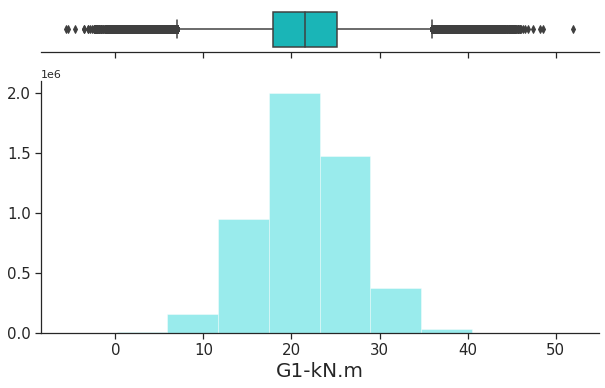

In [ ]:
PRINT_FIGURE_BOXHISTOGRAM(reliability['G1'], 'G1-kN.m', 'G1_final', '#00CED1')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


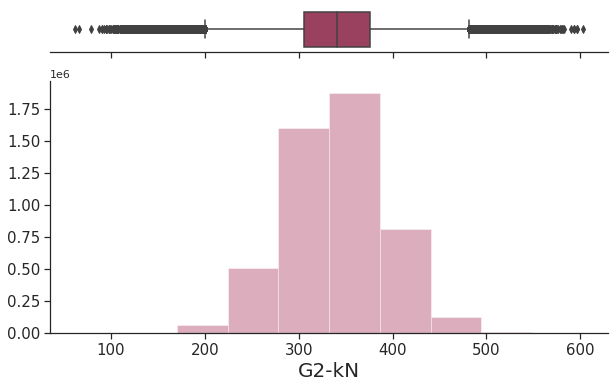

In [ ]:
PRINT_FIGURE_BOXHISTOGRAM(reliability['G2'], 'G2-kN', 'G2_final', '#a8325a')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


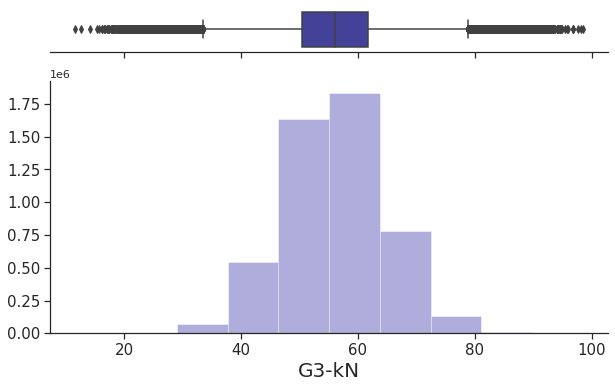

In [ ]:
PRINT_FIGURE_BOXHISTOGRAM(reliability['G3'], 'G3-kN', 'G3_final', '#3632a8')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


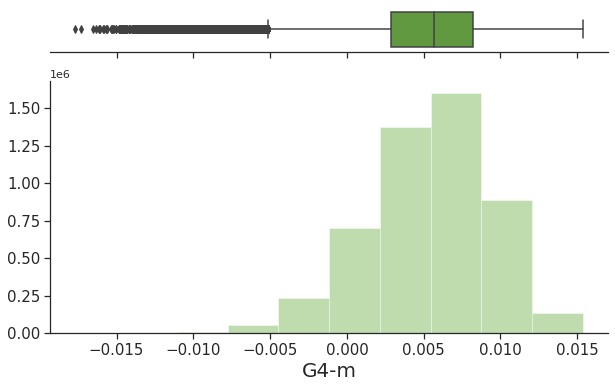

In [ ]:
PRINT_FIGURE_BOXHISTOGRAM(reliability['G4'], 'G4-m', 'G4_final', '#5da832')

In [ ]:
reliability['CAPACITY'].describe()

In [ ]:
PRINT_FIGURE_BOXHISTOGRAM(reliability['LOAD'], 'Dead Load kN/m', 'Dead Load', '#00CED1')

In [ ]:
import random
import numpy
from matplotlib import pyplot

x = reliability['LOAD']
y = reliability['CAPACITY']

bins = numpy.linspace(0, 100, 100)

pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

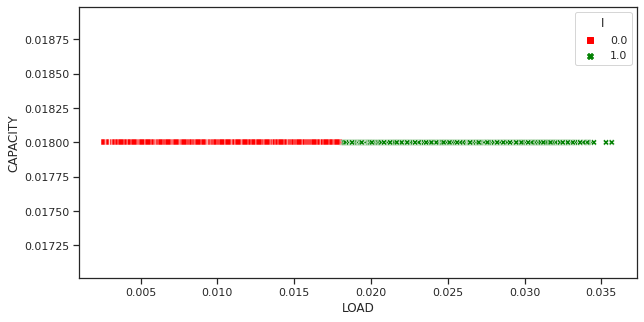

In [ ]:
markers = {0.0: "s", 1.0: "X"}
color = {0.0:'red', 1.0:'green'}
transp = {0.0:0.1, 1.0:0.9}
tamanho = {0.0:0.1, 1.0:0.9}
plt.figure(figsize=(10,5))
sns.scatterplot(data=reliabilityG4, x='LOAD', y='CAPACITY', hue='I', style ='I', palette=color, markers=markers, color = 'darkred')


In [ ]:
nf = reliabilityG1['I'].sum()
print(nf)
probabilityFailure=(nf / totalSamples)
print(probabilityFailure)

141.0
2.82e-05


In [ ]:
reliabilityG1.head(50)

,X1,X2,X3,X4,X5,X6,CAPACITY,LOAD,G1,I
0,13.121845,1.677194,30853.295471,539589.203110,0.907446,1.024260,52.071009,38.368838,13.702171,0.0
1,10.834437,1.786414,25321.083227,547462.835817,1.012921,1.006072,58.135332,32.140505,25.994827,0.0
2,9.591157,1.656279,26192.391063,572702.674662,1.043289,0.880558,62.585547,25.069563,37.515984,0.0
3,11.974737,2.012508,28445.901752,532736.183868,1.009207,1.021944,56.931664,36.182160,20.749504,0.0
4,13.880745,1.637867,32005.735850,524357.096447,0.884916,1.073348,49.531995,42.162702,7.369293,0.0
5,14.744125,1.944786,28320.414822,565205.140424,0.944980,1.054575,56.317854,44.549265,11.768589,0.0
6,11.556241,1.664897,23110.470067,570897.198278,1.092761,1.005159,64.700643,33.638664,31.061979,0.0
7,12.195422,1.581282,33599.749121,544141.031451,1.023250,1.067789,59.474308,37.236243,22.238065,0.0
8,11.923931,2.128686,32432.276345,511211.580092,0.998171,0.930049,54.586231,33.082469,21.503762,0.0
9,11.913092,1.628994,25069.069690,547532.770680,0.986579,1.029265,56.587305,35.281561,21.305744,0.0


In [ ]:
numberFailureFinal

In [ ]:
teste=reliability[reliability['I']==0.0]

In [ ]:
teste.sort_values(by='G')

In [ ]:
pd.DataFrame(gfunction1)

,0,1,2,3
0,51.642036,32.110179,19.531857,0.0
1,50.408435,37.452032,12.956403,0.0
2,60.142173,30.269577,29.872596,0.0
3,56.618681,31.962555,24.656126,0.0
4,53.253822,36.074957,17.178866,0.0
5,53.047484,39.636648,13.410835,0.0
6,56.943750,40.138274,16.805476,0.0
7,60.546206,33.105521,27.440684,0.0
8,53.768019,38.255513,15.512506,0.0
9,64.709129,41.163553,23.545576,0.0
